## Implementing a Custom BERT Model for Spam Prediction

### Import Libraries

In [41]:
import time
import numpy as np
import pandas as pd
import json

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

import transformers
from transformers import AutoModel, BertTokenizerFast

import matplotlib.pyplot as plt

#### Define GPU Here if Available

In [42]:
# device = torch.device("cuda")
device = torch.device("cpu")

### Preprocessing

#### Import the Corpus of Raw Text

In [43]:
# Use this when running the notebook locally
data = pd.read_csv(r"./assets/data/spam-data.csv")

# Running the notebook on Kaggle
# data = pd.read_csv(r"/kaggle/input/spamdatatest/spamdata_v2.csv")

data.head()

label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

### Check the Shape of Data

In [44]:
data.shape

(5572, 2)

#### Check the Way Labels are Distributed

In [45]:
data['label'].value_counts(normalize=True)

0    0.865937
1    0.134063
Name: label, dtype: float64

#### Plot the Bar Plot for the Distribution

In [46]:
data['label'].value_counts(normalize=True).plot.bar()

<AxesSubplot: >

### Split the Data into Training, Testing and Validation Sets

#### Train-test Split

In [47]:
XTrain, XTest, yTrain, yTest = train_test_split(data['text'], data['label'], random_state=42, test_size=0.3, stratify=data['label'])

#### Validation Split

In [48]:
XValidationTrain, XValidationTest, yValidationTrain, yValidationTest = train_test_split(
    XTest, 
    yTest, 
    random_state=42, 
    test_size=0.5, 
    stratify=yTest
)

### Download and Import the Pre-trained BERT Model from Huggingface

In [49]:
# Import the BERT-base pretrained model
BERT = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Get the Length of each Sequence of Text and Plot their Distributions

<AxesSubplot: >

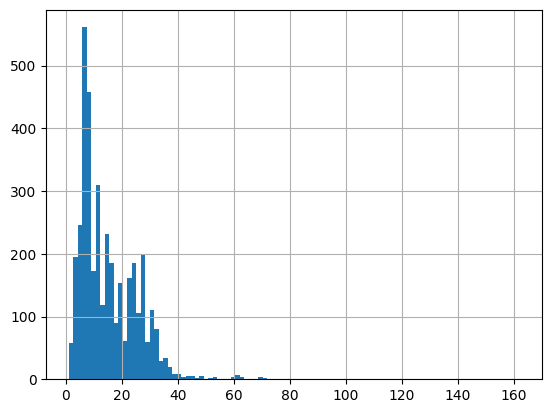

In [50]:
# get length of all the messages in the train set
sequenceLength = [len(sample.split()) for sample in XTrain]

pd.Series(sequenceLength).hist(bins = 100)

### Tokenise and Encode Sequences

In [51]:
# Tokenize and encode sequences in the training set
trainTokens = tokenizer.batch_encode_plus(
    XTrain.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the validation set
validationTokens = tokenizer.batch_encode_plus(
    XValidationTrain.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the test set
testTokens = tokenizer.batch_encode_plus(
    XValidationTest.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/home/volt/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [52]:
type(trainTokens)

transformers.tokenization_utils_base.BatchEncoding

### Convert these Lists to Tensors

In [53]:
trainSequenceTensor = torch.tensor(trainTokens['input_ids'])
trainMaskTensor = torch.tensor(trainTokens['attention_mask'])
trainYTensor = torch.tensor(yTrain.tolist())

validationSequenceTensor = torch.tensor(validationTokens['input_ids'])
validationMaskTensor = torch.tensor(validationTokens['attention_mask'])
validationYTensor = torch.tensor(yValidationTrain.tolist())

testSequenceTensor = torch.tensor(testTokens['input_ids'])
testMaskTensor = torch.tensor(testTokens['attention_mask'])
testYTensor = torch.tensor(yValidationTest.tolist())

#### Here're the Created Tensors

In [54]:
trainSequenceTensor, trainSequenceTensor.shape

(tensor([[  101,  3125,   999,  ...,  1037,  3413,   102],
         [  101,  1045,  2123,  ...,     0,     0,     0],
         [  101,  9779,  2232,  ...,     0,     0,     0],
         ...,
         [  101,  2469,  1010,  ...,  1998,  3227,   102],
         [  101,  2498,  2021,  ...,  2253, 11047,   102],
         [  101,  7087,  1012,  ...,  2061,  1045,   102]]),
 torch.Size([3900, 25]))

In [55]:
testSequenceTensor, testSequenceTensor.shape

(tensor([[  101,  4067,  2017,  ...,     0,     0,     0],
         [  101,  6203,  5718,  ...,  2345,  3535,   102],
         [  101,  2073,  2024,  ...,     0,     0,     0],
         ...,
         [  101,  2053,  1012,  ...,  4309,  2489,   102],
         [  101,  1015,  1045,  ...,  1005,  1040,   102],
         [  101,  2524,  2444,  ..., 21472, 21472,   102]]),
 torch.Size([836, 25]))

In [56]:
validationSequenceTensor, validationSequenceTensor.shape

(tensor([[  101,  5003,  2132,  ...,     0,     0,     0],
         [  101, 11948,  2072,  ...,  1012, 20228,   102],
         [  101, 13433,  2139,  ...,  2050,  1012,   102],
         ...,
         [  101,  2053,  3291,  ...,     0,     0,     0],
         [  101,  1998,  2011,  ...,     0,     0,     0],
         [  101,  2002,  2758,  ...,  1055,  5791,   102]]),
 torch.Size([836, 25]))

### Using the Data Loader in PyTorch to Load the Dataset

#### Define Hyper-parameter(s)

In [57]:
batchSize = 16

#### Create Training Tensors

In [58]:
# Wrapping the training tensors
trainingTensor = TensorDataset(trainSequenceTensor, trainMaskTensor, trainYTensor)

# Randomly Sampling the Wrapped Tensor
trainingSampler = RandomSampler(trainingTensor)

# Putting the training sampled data in a data loader
trainingDataLoader = DataLoader(trainingTensor, sampler=trainingSampler, batch_size=batchSize)

In [59]:
type(trainingTensor), type(trainingSampler), type(trainingDataLoader)

(torch.utils.data.dataset.TensorDataset,
 torch.utils.data.sampler.RandomSampler,
 torch.utils.data.dataloader.DataLoader)

#### Now, the same for Validation Tensors

In [60]:
# Wrapping the validation tensors
validationTensor = TensorDataset(validationSequenceTensor, validationMaskTensor, validationYTensor)

# Randomly Sampling the Wrapped Tensor
validationSampler = RandomSampler(validationTensor)

# Putting the training sampled data in a data loader
validationDataLoader = DataLoader(validationTensor, sampler=validationSampler, batch_size=batchSize)

### Write Tensors to a JSON File

In [61]:
def saveToJSON(filePath, **kwargs):
    """
    Save PyTorch tensors to a JSON file.

    Args:
        file_path (str): Path to the JSON file to save to.
        **kwargs: Key-value pairs where the key is the name of the tensor and the value is the tensor to save.
    """
    toSave = {}
    
    for name, variable in kwargs.items():
        variableType = type(variable)
        
        if variableType == list or variableType == int:
            toSave[name] = variable
        else:
            toSave[name] = variable.tolist()
    
    with open(filePath, 'w') as f:
        json.dump(toSave, f)

### Construct the BERT Model

In [62]:
# Freeze all the parameters
for parameter in BERT.parameters():
    parameter.requires_grad = False

In [63]:
class BERTArchitecture(nn.Module):
    def __init__(self, bert):
        super(BERTArchitecture, self).__init__()
        
        self.bert = bert 
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # ReLU activation function
        self.relu =  nn.ReLU()

        # Dense layer 1
        self.fullyConnected1 = nn.Linear(768, 512)
      
        # Dense layer 2 (Output layer)
        self.fullyConnected2 = nn.Linear(512, 2)

        # Softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):
        # Pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        # Input layer
        x = self.fullyConnected1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # Output layer
        x = self.fullyConnected2(x)
      
        # Apply softmax activation
        x = self.softmax(x)

        return x

### Pass the Pre-trained BERT from Huggingface to our Defined Architecture

In [64]:
model = BERTArchitecture(BERT)

#### Push our Model to the Device

In [65]:
model = model.to(device)

### Create an Optimiser

In [66]:
# Optimizer from hugging face transformers
from transformers import AdamW

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

/home/volt/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Compute Class Weights

In [67]:
weightsList = compute_class_weight(class_weight='balanced', classes=np.unique(yTrain), y=yTrain)

print("Class Weights:", weightsList)

Class Weights: [0.57743559 3.72848948]


#### Convert Class Weights List to Tensor

In [68]:
# Converting list of class weights to a tensor
weights = torch.tensor(weightsList, dtype=torch.float)

# Push to GPU
weights = weights.to(device)

### Define Hyper-parameters to Train

In [69]:
# Define the loss function
crossEntropy  = nn.NLLLoss(weight=weights) 

# Define the number of training epochs
epochs = 1

# Define how many steps before printing an update
trainingStepsUpdate = 20
validationStepsUpdate = 10

### Training the Model - Fine Tuning
Define a function to train the model.

In [70]:
def train():
    model.train()
    totalLoss = 0
  
    # Empty list to save model predictions
    totalPredictions = []
  
    # Iterate over batches
    for step, batch in enumerate(trainingDataLoader):
        # Progress update after every 50 batches.
        if step % trainingStepsUpdate == 0 and not step == 0:
            print('\tBatch {:>3,} of {:>3,}.'.format(step, len(trainingDataLoader)))
        
        # Push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # Clear previously calculated gradients 
        model.zero_grad()        

        # Get model predictions for the current batch
        preds = model(sent_id, mask)

        # Compute the loss between actual and predicted values
        loss = crossEntropy(preds, labels)

        # Add on to the total loss
        totalLoss = totalLoss + loss.item()

        # Backward pass to calculate the gradients
        loss.backward()

        # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

    # Append the model predictions
    totalPredictions.append(preds)

    # Compute the training loss of the epoch
    averageLoss = totalLoss / len(trainingDataLoader)
  
    # Predictions are in the form of (no. of batches, size of batch, no. of classes). Reshape the predictions in form of (number of samples, no. of classes)
    totalPredictions  = np.concatenate(totalPredictions, axis=0)

    # Returns the loss and predictions
    return averageLoss, totalPredictions

### Evaluating the Model - Using the Validation Set
Define a function to evaluate the model.

In [71]:
def evaluate():
    print("\nEvaluating...")
  
    # Deactivate dropout layers
    model.eval()

    totalLoss = 0
    
    # Empty list to save the model predictions
    totalPredictions = []

    # Iterate over batches
    for step, batch in enumerate(validationDataLoader):
        # Progress update every 50 batches.
        if step % validationStepsUpdate == 0 and not step == 0:
            # Report progress.
            print('\tBatch {:>3,} of {:>3,}.'.format(step, len(validationDataLoader)))

        # Push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # Deactivate autograd
        with torch.no_grad():
            
            # Model predictions
            preds = model(sent_id, mask)

            # Compute the validation loss between actual and predicted values
            loss = crossEntropy(preds,labels)

            totalLoss = totalLoss + loss.item()

            preds = preds.detach().cpu().numpy()

            totalPredictions.append(preds)

    # Compute the validation loss of the epoch
    averageLoss = totalLoss / len(validationDataLoader) 

    # Reshape the predictions in form of (number of samples, no. of classes)
    totalPredictions  = np.concatenate(totalPredictions, axis=0)

    return averageLoss, totalPredictions

### Running the Model to Train and Evaluate

In [72]:
# Set initial loss to infinite
bestValidationLoss = float('inf')

# Empty lists to store training and validation loss of each epoch
trainingLosses = []
validationLosses = []

# Initialize total time taken to 0
totalTimeTaken = 0

# For each epoch
for epoch in range(epochs):
    print('\nEpoch {:} of {:}'.format(epoch + 1, epochs))
    
    # Train model and record time taken
    startTime = time.time()
    trainingLoss, _ = train()
    trainingTimeTaken = time.time() - startTime

    # Evaluate model and record time taken
    startTime = time.time()
    validationLoss, _ = evaluate()
    validationTimeTaken = time.time() - startTime

    # Save the best model
    if validationLoss < bestValidationLoss:
        bestValidationLoss = validationLoss
        
        # When running the notebook on a Kaggle kernel
        # torch.save(model.state_dict(), r'/kaggle/working/weights.pt')
        
        # When saving the weights locally
        torch.save(model.state_dict(), r'./assets/weights/weights.pt')
    
    # Append training and validation losses
    trainingLosses.append(trainingLoss)
    validationLosses.append(validationLoss)
    
    # Print epoch results and times taken
    print(f'\nTraining Loss: {trainingLoss:.3f}')
    print(f'Training Time Taken: {trainingTimeTaken:.2f} seconds')
    print(f'Validation Loss: {validationLoss:.3f}')
    print(f'Validation Time Taken: {validationTimeTaken:.2f} seconds')

    # Update total time taken
    totalTimeTaken += trainingTimeTaken + validationTimeTaken

# Print total time taken for all epochs
print(f'\nTotal Time Taken: {totalTimeTaken:.2f} seconds')


Epoch 1 of 1
	Batch  20 of 244.
	Batch  40 of 244.
	Batch  60 of 244.
	Batch  80 of 244.
	Batch 100 of 244.
	Batch 120 of 244.
	Batch 140 of 244.
	Batch 160 of 244.
	Batch 180 of 244.
	Batch 200 of 244.
	Batch 220 of 244.
	Batch 240 of 244.

Evaluating...
	Batch  10 of  53.
	Batch  20 of  53.
	Batch  30 of  53.
	Batch  40 of  53.
	Batch  50 of  53.

Training Loss: 0.661
Training Time Taken: 104.47 seconds
Validation Loss: 0.642
Validation Time Taken: 18.05 seconds

Total Time Taken: 122.52 seconds


In [73]:
# Save tensors to a JSON file
saveToJSON('./assets/tensors/tensors.json', testSequenceTensor=testSequenceTensor, testMaskTensor=testMaskTensor, testYTensor=testYTensor, trainingLossTensor=trainingLosses, validationLossTensor=validationLosses, epochs=epochs)

---